In [1]:
# import all libraries

import glob
import time
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label

%matplotlib inline

## Feature Extraction

### Compute HOG features

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Spatial binning of color features

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features

### Color histogram features

In [4]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Extract all features in a given color space

In [5]:
# Define a function to extract features from a single image
def extract_features(image, color_space_spatial='RGB', 
                     color_space_hist='RGB', color_space_hog='RGB',
                     spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    
    img_features = []
    
    # compute spatial binning features
    if spatial_feat == True:
        
        # apply color conversion if other than 'RGB'
        if color_space_spatial != 'RGB':
            feature_image = cv2.cvtColor(image, eval('cv2.COLOR_RGB2'+color_space_spatial))
        else: 
            feature_image = np.copy(image)
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # append the new feature vector to the features list
        img_features.append(spatial_features)
      
    # compute histogram features
    if hist_feat == True:
        
        # apply color conversion if other than 'RGB'
        if color_space_hist != 'RGB':
            feature_image = cv2.cvtColor(image, eval('cv2.COLOR_RGB2'+color_space_hist))
        else: 
            feature_image = np.copy(image)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # append the new feature vector to the features list
        img_features.append(hist_features)
    
    # compute HOG features
    if hog_feat == True:
        
        # apply color conversion if other than 'RGB'
        if color_space_hog != 'RGB':
            feature_image = cv2.cvtColor(image, eval('cv2.COLOR_RGB2'+color_space_hog))
        else: 
            feature_image = np.copy(image)
            
        # extract HOG features for a given channel
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # append the new feature vector to the features list
        img_features.append(hog_features)
     
    # return a vector which is a concatenation of all features
    return np.concatenate(img_features)
        

# Define a function to extract features from a list of files
# This function returns a list of feature vectors, one for each file in the list
def extract_features_files(imgs, color_space_spatial='RGB', color_space_hist='RGB', color_space_hog='RGB',
                           spatial_size=(32, 32),
                           hist_bins=32, orient=9, 
                           pix_per_cell=8, cell_per_block=2, hog_channel=0,
                           spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        
        # Read in each one by one
        image = mpimg.imread(file)
        image_features = extract_features(image, color_space_spatial, color_space_hist, color_space_hog,
                                          spatial_size, hist_bins, orient, pix_per_cell, 
                                          cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
        features.append(image_features)
             
    # Return list of feature vectors
    return features

## Draw bounding boxes

In [6]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

## Sliding window search and classification

In [7]:
# Define a single function that can slide search windows, extract features using hog sub-sampling and classify search windows
def find_cars(img, window_size, y_start_stop, svc, X_scaler, 
              color_space_spatial='RGB', color_space_hist='RGB', color_space_hog='RGB',
              orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32,32), hist_bins=32, hist_range=(0, 256),
              hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, visualize=False):
    
    # 64x64 was the size of the image in the training set
    orig_window = 64
    
    if visualize == True:
        imcopy = np.copy(img)
        
    # crop the part of the image where road is located
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    
    # initialize list of boxes
    on_windows = []
    
    # scale image so that a window of window_size will have a size 64x64
    scale_x = window_size[0] / orig_window
    scale_y = window_size[1] / orig_window
    
    if scale_x != 1 or scale_y != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale_y), np.int(imshape[0]/scale_x))) 
    
    # define blocks and step sizes
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # define number of features in each block
    nfeat_per_block = orient*cell_per_block**2
    
    # compute number of blocks in search window 
    nblocks_per_window = (orig_window // pix_per_cell) - cell_per_block + 1
    
    # define how many cells to step
    cells_per_step = 2 
    
    # define number of steps in the sliding window search
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # compute individual channel HOG features for the entire image
    if hog_feat == True:
        
        # apply color conversion if other than 'RGB'
        if color_space_hog != 'RGB':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, eval('cv2.COLOR_RGB2'+color_space_hog))
        else: 
            ctrans_tosearch = np.copy(img_tosearch)

        if hog_channel == 'ALL':
            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]

            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        else:
            ch = ctrans_tosearch[:,:,hog_channel]
            hog_features = get_hog_features(ch, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # create image in the color space of spatial binning features
    if spatial_feat == True:
        if color_space_spatial != 'RGB':
            feature_image_spatial = cv2.cvtColor(img_tosearch, eval('cv2.COLOR_RGB2'+color_space_spatial))
        else: 
            feature_image_spatial = np.copy(img_tosearch)
    
    # create image in the color space in histogram features 
    if hist_feat == True:
        if color_space_hist != 'RGB':
            feature_image_hist = cv2.cvtColor(img_tosearch, eval('cv2.COLOR_RGB2'+color_space_hist))
        else: 
            feature_image_hist = np.copy(img_tosearch)
    
    # perform sliding window search
    for xb in range(nxsteps):
        for yb in range(nysteps):
            img_features = np.array([]) 
            
            # compute position of the image in cell space
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # compute position of the image in pixel space
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
        
            # compute spatial binning features
            if spatial_feat == True:
                subimg = feature_image_spatial[ytop:ytop+orig_window, xleft:xleft+orig_window]
                spatial_features = bin_spatial(subimg, size=spatial_size)
                img_features = np.hstack((img_features, spatial_features))
                
            # compute histogram features    
            if hist_feat == True:
                subimg = feature_image_hist[ytop:ytop+orig_window, xleft:xleft+orig_window]
                hist_features = color_hist(subimg, nbins=hist_bins)
                img_features = np.hstack((img_features, hist_features))
            
            # compute HOG features for a given channel
            if hog_feat == True:
                if hog_channel == 'ALL':
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features_all = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features_all = hog_features[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                img_features = np.hstack((img_features, hog_features_all))
        
            # normalize features
            test_features = X_scaler.transform(img_features.reshape(1, -1))       
            
            # get binary prediction (car/not a car)
            test_prediction = svc.predict(test_features)
            
            # get car detection score
            test_score = svc.decision_function(test_features)
                
            # if positive prediction or visuzalization mode  
            if test_prediction == 1 or visualize == True:
                
                # rescale the search window to the original image space
                xbox_left = np.int(xleft*scale_x)
                ytop_draw = np.int(ytop*scale_y)
                win_draw_x = np.int(orig_window*scale_x)
                win_draw_y = np.int(orig_window*scale_y)
                
                if test_prediction == 1:
                    # add search window to the list of positively classified windows
                    on_windows.append([(xbox_left, ytop_draw+y_start_stop[0]), 
                                       (xbox_left+win_draw_x, ytop_draw+win_draw_y+y_start_stop[0]),test_score])
                    
                if visualize == True:
                    # visualize a search window
                    imcopy = cv2.rectangle(imcopy, (xbox_left, ytop_draw+y_start_stop[0]), 
                                                   (xbox_left+win_draw_x, ytop_draw+win_draw_y+y_start_stop[0]), 
                                           color=(0,0,1), thickness=6)
    
    # if visualization mode then save the image with all positively classified search windows
    if visualize == True:
        mpimg.imsave('output_images/search_windows'+str(counter)+'.png', imcopy) 
    
    # return a list of positively classified search windows
    return on_windows

## Auxiliary functions for merging bounding boxes

In [8]:
# Define a function to update a heatmap
def add_heat(heatmap, bbox_list):
    
    # iterate through list of bounding boxes
    for box in bbox_list:
        
        # assign to each pixel a maximum value of the scores of all boxes covering it
        # assuming each "box" takes the form ((x1, y1), (x2, y2), score)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] = np.maximum(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]],\
                                                                       box[2])

    # return an updated heatmap
    return heatmap

# Define a function that applies threshold to a heatmap
def apply_threshold(heatmap, threshold):
    
    # zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # return thresholded map
    return heatmap

# Define a function that finds a bounding box for each labelled region  
def find_labeled_bboxes(img, labels):
    
    boxes = []
    
    # iterate through all labelled regions
    for region_number in range(1, labels[1]+1):
        
        # find pixels with label value
        nonzero = (labels[0] == region_number).nonzero()
    
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # define a bounding box based on min/max x and y
        min_x = np.min(nonzerox)
        min_y = np.min(nonzeroy)
        max_x = np.max(nonzerox)
        max_y = np.max(nonzeroy)
        center = ((max_x+min_x)/2, (max_y+min_y)/2)
        bbox = ((min_x, min_y), (max_x, max_y), center)
        boxes.append(bbox)
        
    return boxes

# Define a function that draws labeled boxes
def draw_labeled_bboxes(img, labels):
    
    # make a copy of the image
    imcopy = np.copy(img)
    
    # iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # draw the box on the image
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
    
    return imcopy

## Hyperparameters of feature computation, object detection and tracking

In [9]:
color_space_hog = 'LUV'          # color space of HOG features 
color_space_hist = 'RGB'         # color space of histogram features
color_space_spatial = 'RGB'      # color space of spatial binning features
orient = 9                       # HOG orientations
pix_per_cell = 8                 # HOG pixels per cell
cell_per_block = 2               # HOG cells per block
hog_channel = 0                  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)          # Spatial binning dimensions
hist_bins = 16                   # Number of histogram bins
hist_range = (0, 1)              # Range of x values of histogram
spatial_feat = True              # Spatial features on or off
hist_feat = True                 # Histogram features on or off
hog_feat = True                  # HOG features on or off
y_start_stop = [400, 650]        # min and max in y to search in slide_window()
window_sizes = [(96,96)]         # sizes of the search windows
min_age_to_be_visible = 20       # minimum age of the detected object to be drawn in the video frame 
distance_threshold = 70          # maximal distance between bounding box centers to match previously detected object 
                                 # and the newly found bounding box
alpha = 0.5                      # smoothing parameter

## Data Exploration and Visualization

### Read the dataset

In [10]:
# Read in cars and not cars
images = glob.iglob('dataset\\**\\*.png', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

n_cars = len(cars)
n_notcars = len(notcars)
print('Cars images: {}'.format(n_cars))
print('Not cars images: {}'.format(n_notcars))

Cars images: 8792
Not cars images: 8968


### Show sample images from the dataset

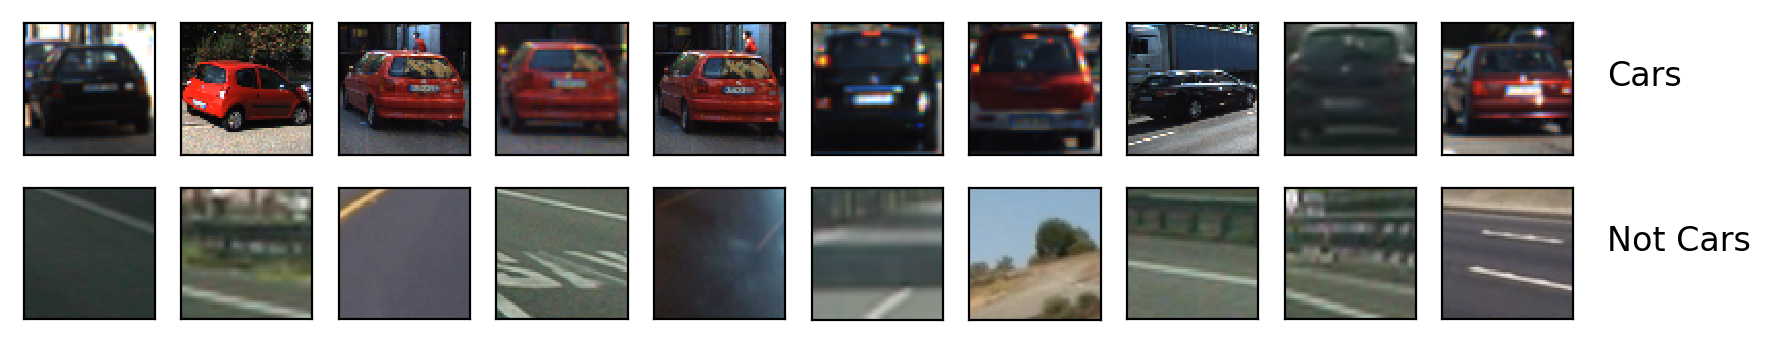

In [11]:
import random

# auxiliary function
def remove_axes(fig):
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
n_samples = 10

# show examples of cars and not cars
ind_all = np.arange(n_cars)
car_ids = random.sample(list(ind_all), n_samples)
car_image_names = np.array(cars)[car_ids]

ind_all = np.arange(n_notcars)
notcar_ids = random.sample(list(ind_all), n_samples)
notcar_image_names = np.array(notcars)[notcar_ids]

X = np.empty((n_samples*2,64,64,3), dtype=np.float32)

for i, car_image in enumerate(car_image_names):
    X[i,:,:,:] = mpimg.imread(car_image)
    
for i, notcar_image in enumerate(notcar_image_names):
    X[n_samples+i,:,:,:] = mpimg.imread(notcar_image)


fig = plt.figure(figsize=(n_samples,2),dpi=200)

for i in range(2*n_samples):
    plt.subplot(2,n_samples,1+i)
    fig = plt.imshow(X[i,:,:,:])
    remove_axes(fig)

plt.subplot(2,n_samples,n_samples)
plt.text(80, 30, "Cars", fontsize=12)
plt.subplot(2,n_samples,n_samples*2)
plt.text(80, 30, "Not Cars", fontsize=12)

plt.savefig('.\\examples\\cars_not_cars.png',dpi='figure',bbox_inches='tight', pad_inches=0)

### Show examples of HOG features

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


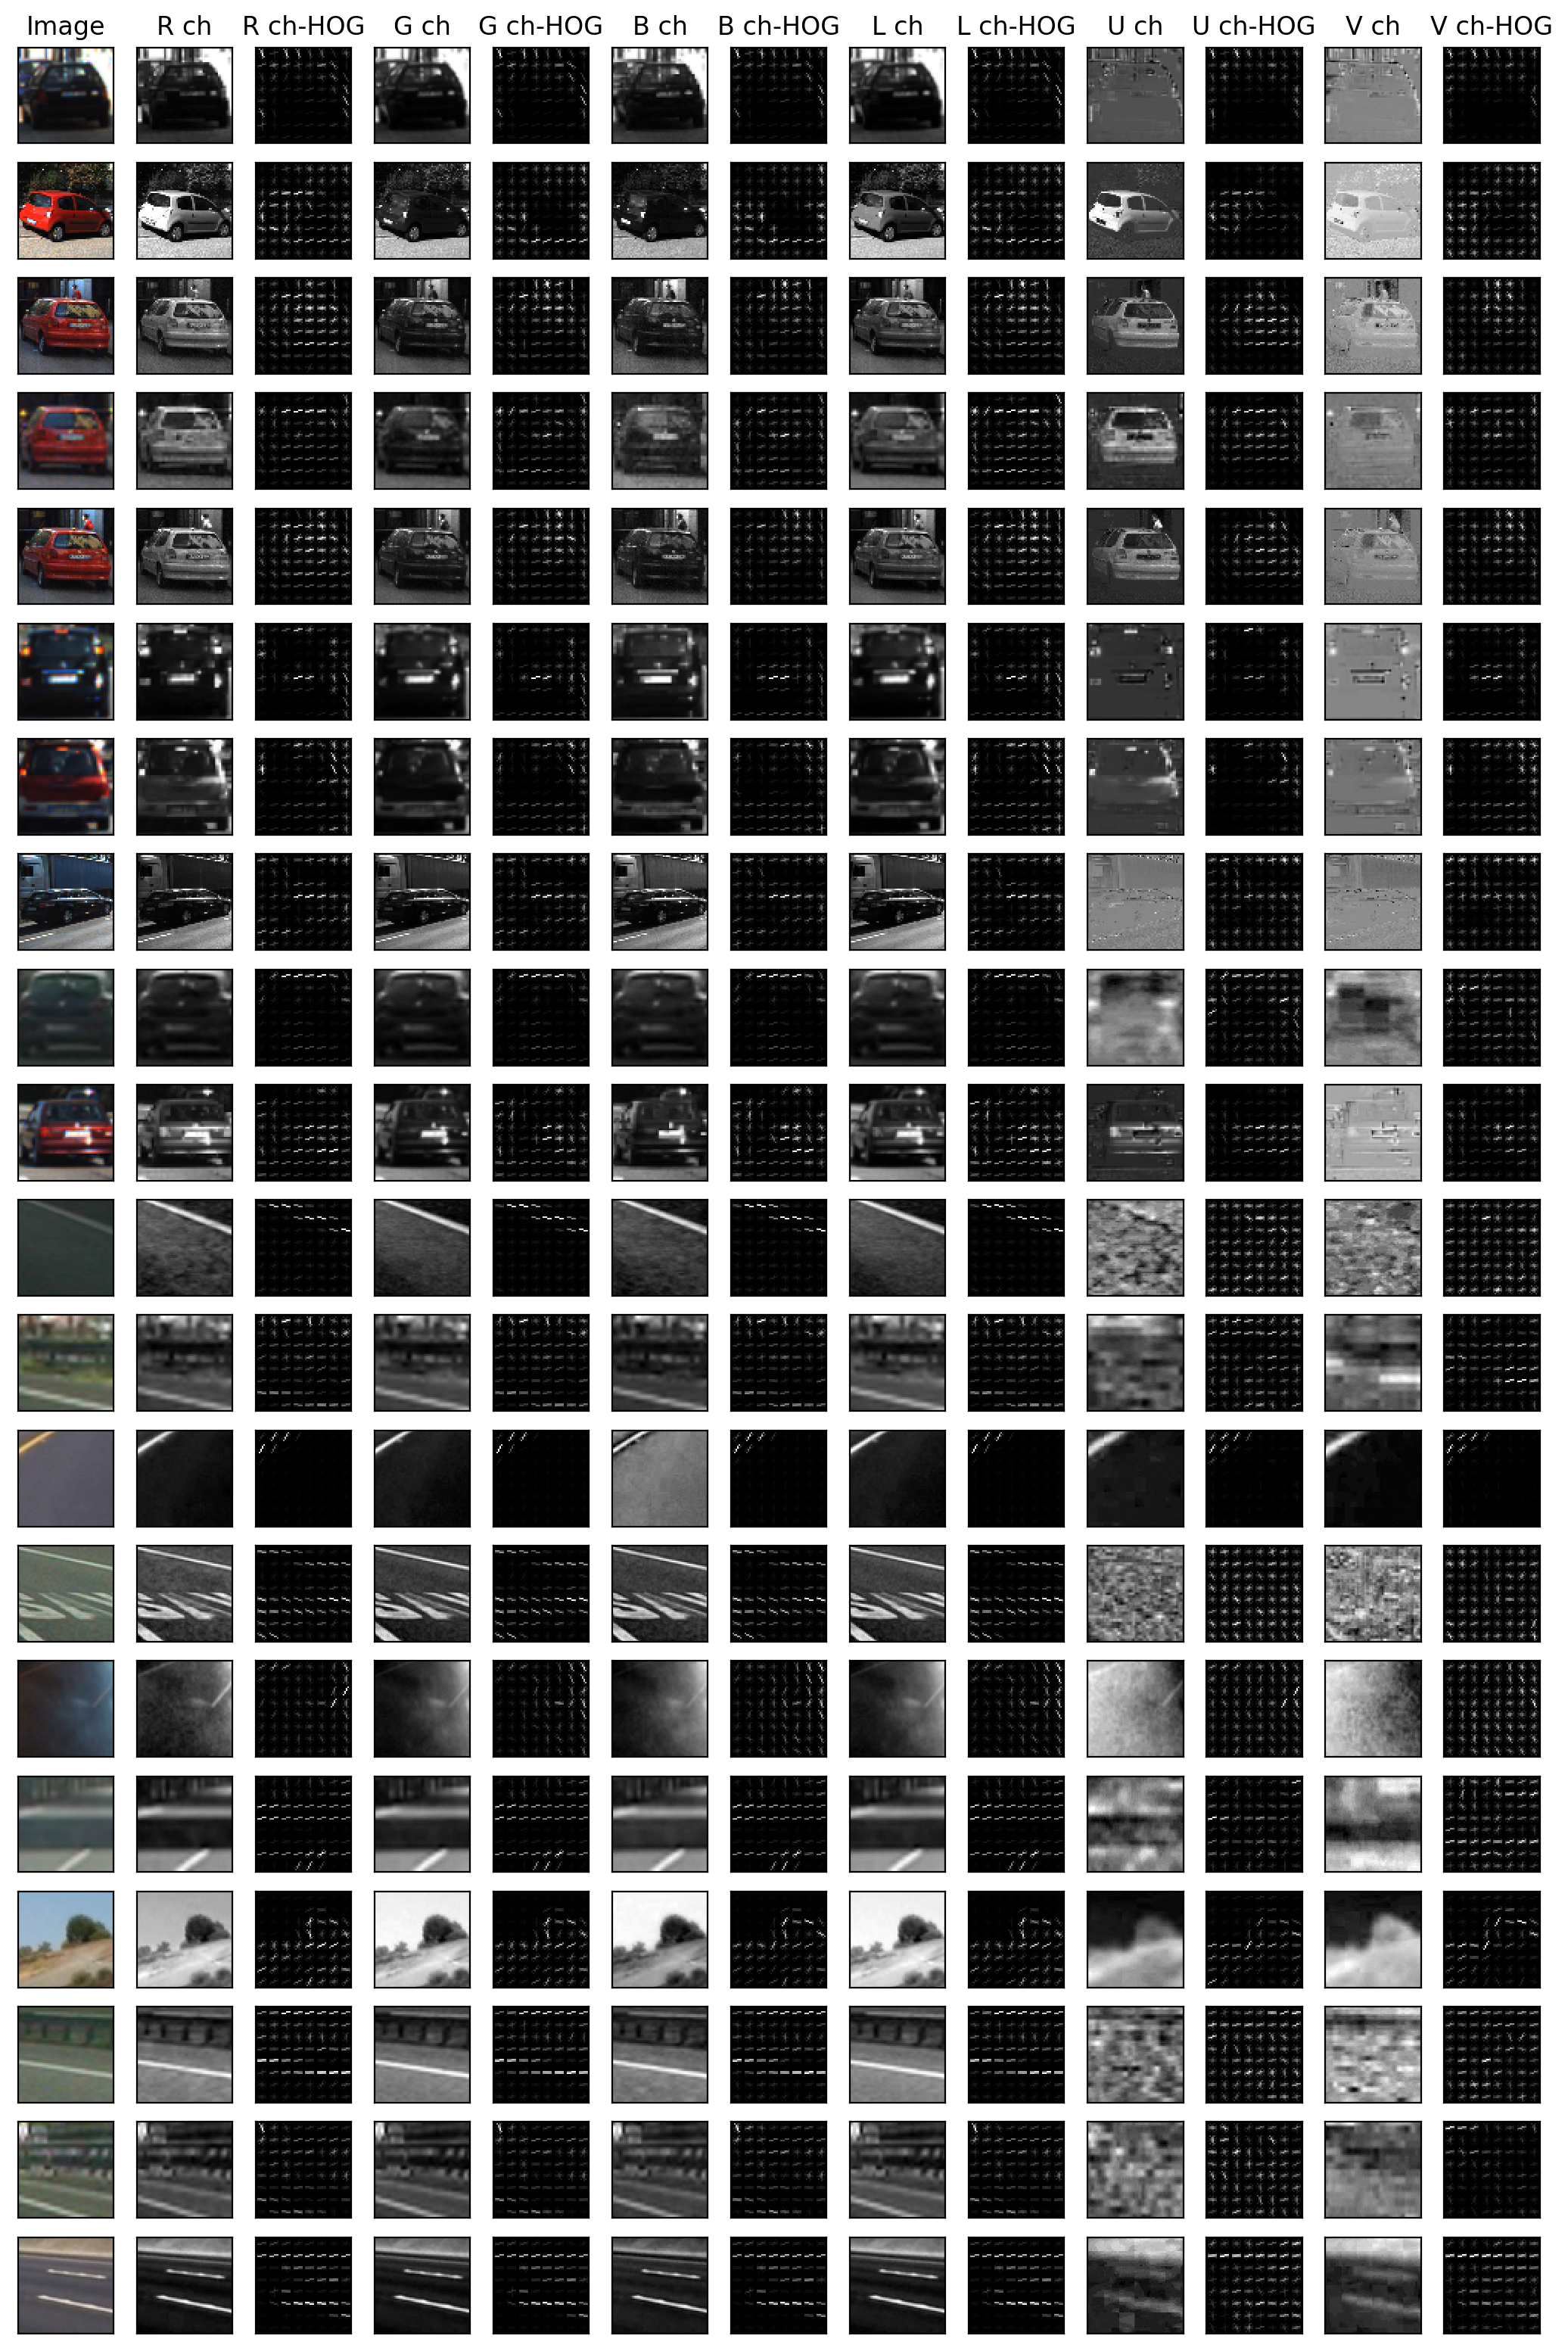

In [12]:
hog_images = np.empty((n_samples*2,6,64,64),dtype=np.float32) 
luv_images = np.empty((n_samples*2,64,64,3),dtype=np.float32)

for i in range(2*n_samples):
    luv_images[i,:,:,:] = cv2.cvtColor(X[i,:,:,:], cv2.COLOR_RGB2LUV)
    for j in range(3):
        features, hog_images[i,j,:,:] = get_hog_features(X[i,:,:,j], orient, pix_per_cell, cell_per_block, 
                                                         vis=True, feature_vec=False)
        features, hog_images[i,j+3,:,:] = get_hog_features(luv_images[i,:,:,j], orient, pix_per_cell, cell_per_block, 
                                                           vis=True, feature_vec=False)
        
fig = plt.figure(figsize=(13, 2*n_samples),dpi=200)
names = ['R ch','R ch-HOG','G ch','G ch-HOG','B ch','B ch-HOG','L ch','L ch-HOG','U ch','U ch-HOG','V ch','V ch-HOG',]
for i in range(2*n_samples):
    plt.subplot(2*n_samples,13,1+13*i)
    fig = plt.imshow(X[i,:,:,:])
    if i == 0:
        fig.axes.set_title('Image')
    remove_axes(fig)
    for j in range(6):
        plt.subplot(2*n_samples,13,13*i+1+1+j*2)
        if j < 3:
            fig = plt.imshow(X[i,:,:,j],cmap='gray')
        else:
            fig = plt.imshow(luv_images[i,:,:,j-3],cmap='gray')
        if i == 0:
            fig.axes.set_title(names[j*2]) 
        remove_axes(fig)
        plt.subplot(2*n_samples,13,13*i+2+j*2+1)
        fig = plt.imshow(hog_images[i,j,:,:],cmap='gray')
        if i == 0:
            fig.axes.set_title(names[j*2+1]) 
        remove_axes(fig)
        
plt.savefig('.\\examples\\hog_features.png',dpi='figure',bbox_inches='tight', pad_inches=0)

## Main code for training classifier

In [13]:
# extract features from the images in all input files
X = extract_features_files(cars + notcars, color_space_spatial=color_space_spatial, 
                           color_space_hist=color_space_hist, color_space_hog=color_space_hog, 
                           spatial_size=spatial_size, hist_bins=hist_bins, 
                           orient=orient, pix_per_cell=pix_per_cell, 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, spatial_feat=spatial_feat, 
                           hist_feat=hist_feat, hog_feat=hog_feat)

# define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

# split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X[0]))

# fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# apply the scaler to the dataset
scaled_X = X_scaler.transform(X)

# define linear SVM, the grid of value of its hyperparameter C and cross-validation object
svc = LinearSVC()
parameters = {'C':[0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
clf = GridSearchCV(svc, parameters, cv=2)

# find the best value of C using cross-validation, use that value to train the model over the entire dataset
clf.fit(scaled_X, y)

print(clf.best_params_)
print('Cross-validation Accuracy of SVC = ', round(clf.best_score_, 4))

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
{'C': 1e-05}
Cross-validation Accuracy of SVC =  0.8875


## Main code for detecting cars and drawing bounding boxes

In [14]:
# Class that represents detected object
class Object():
    def __init__(self, box, center):
        self.box = [[box[0][0],box[0][1]],[box[1][0],box[1][1]]]
        self.center = center
        self.age = 1
        self.updated = True
     
    # return bounding box of the object
    def get_box(self):
        return ((self.box[0][0],self.box[0][1]),(self.box[1][0],self.box[1][1]))
    
    # return True iff the bounding box of the object can be drawn in the video frame
    def is_visible(self):
        return self.age > min_age_to_be_visible
    
    # check if the object is close to a given bounding box 
    def is_similar(self, center):
        if abs(self.center[0] - center[0]) < distance_threshold and abs(self.center[1] - center[1]) < distance_threshold:
            return True
        else:
            return False
    
    # update object with the new bounding box
    def update(self, box):
        self.box[0][0] = int((1-alpha) * self.box[0][0] + alpha * box[0][0])
        self.box[0][1] = int((1-alpha) * self.box[0][1] + alpha * box[0][1])
        self.box[1][0] = int((1-alpha) * self.box[1][0] + alpha * box[1][0])
        self.box[1][1] = int((1-alpha) * self.box[1][1] + alpha * box[1][1])
        self.center = (0.5*(self.box[0][0]+self.box[1][0]),0.5*(self.box[0][1]+self.box[1][1]))
        self.age += 1
        self.updated = True
    
    # update the age of the object if it is not detected in the last frame
    def reset_update(self):
        if self.updated == False:
            self.age /= 1.1 
        else:
            self.updated = False
        return self.age

## Detect objects in a single image

In [18]:
# Define a function that detects objects in a single image
def process_image(image, visualize=False):
    
    # we extracted training data from .png images (scaled 0 to 1 by mpimg) and 
    # the image we are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    hot_windows_all = []
    
    # go over all window sizes
    for window_size in window_sizes:
        
        # find positively classified bounding boxes
        hot_windows = find_cars(image, window_size, y_start_stop, clf, X_scaler, 
                                color_space_spatial=color_space_spatial, 
                                color_space_hist=color_space_hist, color_space_hog=color_space_hog,
                                spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat, visualize=visualize) 
        
        hot_windows_all += hot_windows

    if visualize == True:
        draw_image = np.copy(image)
        window_img = draw_boxes(draw_image, hot_windows_all, color=(0, 0, 1), thick=6) 
        mpimg.imsave('output_images/boxes'+str(counter)+'.png', window_img) 
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # build a heatmap
    heat = add_heat(heat,hot_windows_all)
    
    # apply threshold to help remove false positives
    heat = apply_threshold(heat,0.35)   
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    if visualize == True:
        mpimg.imsave('output_images/heatmap'+str(counter)+'.png', heatmap, cmap='hot')
        mpimg.imsave('output_images/labels'+str(counter)+'.png', labels[0], cmap='gray')
    
    return labels

## Detect objects in a video stream

In [16]:
counter = 0              # counter of the video frames
detected_objects = []    # list of currently detected objects

# Define a function that detects objects in a video stream
def process_image_continuous(image, visualize=False):
    global counter, detected_objects
    
    # get coordinates of the bounding boxes 
    labels = process_image(image, visualize)
    boxes_frame = find_labeled_bboxes(image, labels)
    
    # update previously found boxes 
    new_objects = []
    for i, box in enumerate(boxes_frame):
        assigned = False
        for detected_object in detected_objects:
            if detected_object.is_similar(box[2]) == True:
                detected_object.update((box[0],box[1]))
                assigned = True
        if assigned == False:
            new_objects.append(Object((box[0],box[1]),box[2]))
     
    # find the objects that are no longer detected
    detected_objects += new_objects
    to_be_deleted = []
    for i, detected_object in enumerate(detected_objects):
        new_age = detected_object.reset_update()
        if new_age < 1:
            to_be_deleted.append(i)  
    
    # delete bounding boxes of objects that are no longer updated
    for i in sorted(to_be_deleted, reverse=True):
        del detected_objects[i]
    
    # compile list of the objects to be drawn in the current video frame
    boxes_to_be_drawn = []
    for detected_object in detected_objects:
        if detected_object.is_visible() == True:
            boxes_to_be_drawn.append(detected_object.get_box())
    
    # draw bounding boxes
    objects_img = draw_boxes(image, boxes_to_be_drawn)
    
    if visualize == True:
        mpimg.imsave('output_images/video'+str(counter)+'.png', objects_img)
    
    counter += 1
    
    return objects_img

## Run object detection pipeline on test images

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


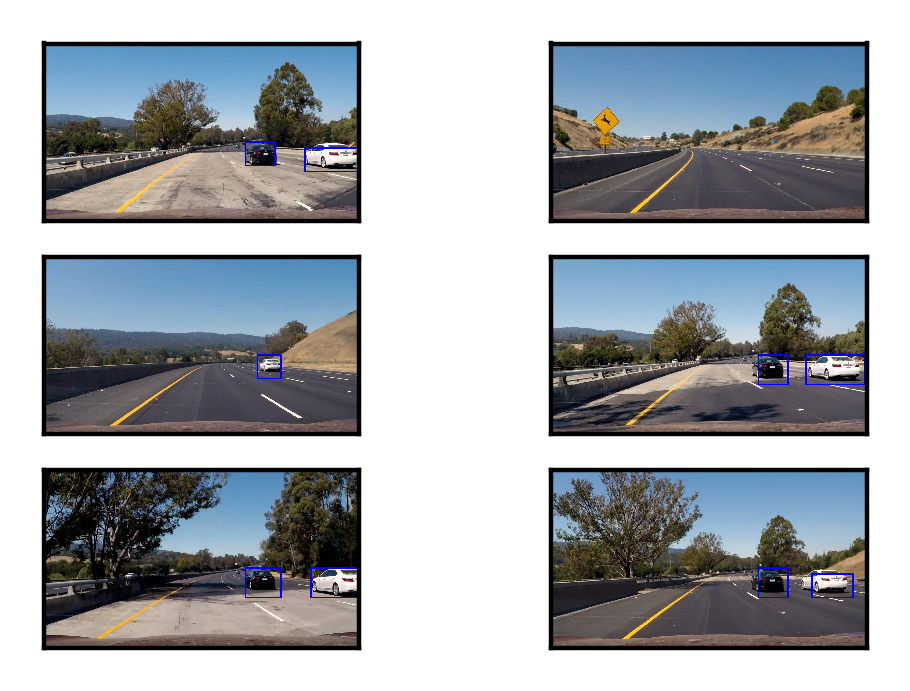

In [19]:
images = glob.iglob('test_images/*.jpg')

fig = plt.figure(figsize=(3, 2),dpi=400)


for i, image_file in enumerate(images):
        
    image = mpimg.imread(image_file)   
    labels = process_image(image, visualize=True)
    objects_img = draw_labeled_bboxes(image, labels)
    
    plt.subplot(3,2,1+i)
    fig = plt.imshow(objects_img)
    remove_axes(fig)
    
plt.savefig('.\\examples\\test_images.png',dpi='figure',bbox_inches='tight', pad_inches=0)

## Run object detection pipeline on test video

In [20]:
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
if not os.path.exists('output_videos'):
    os.makedirs('output_videos')
      
video_name = 'project_video.mp4'
clip = VideoFileClip(video_name)
clip_lanes = clip.fl_image(process_image_continuous)
clip_lanes.write_videofile('output_videos/' + video_name, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:43:42<00:01,  1.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 



In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/' + video_name))

### Create a figure that shows different steps of object detection in a test video

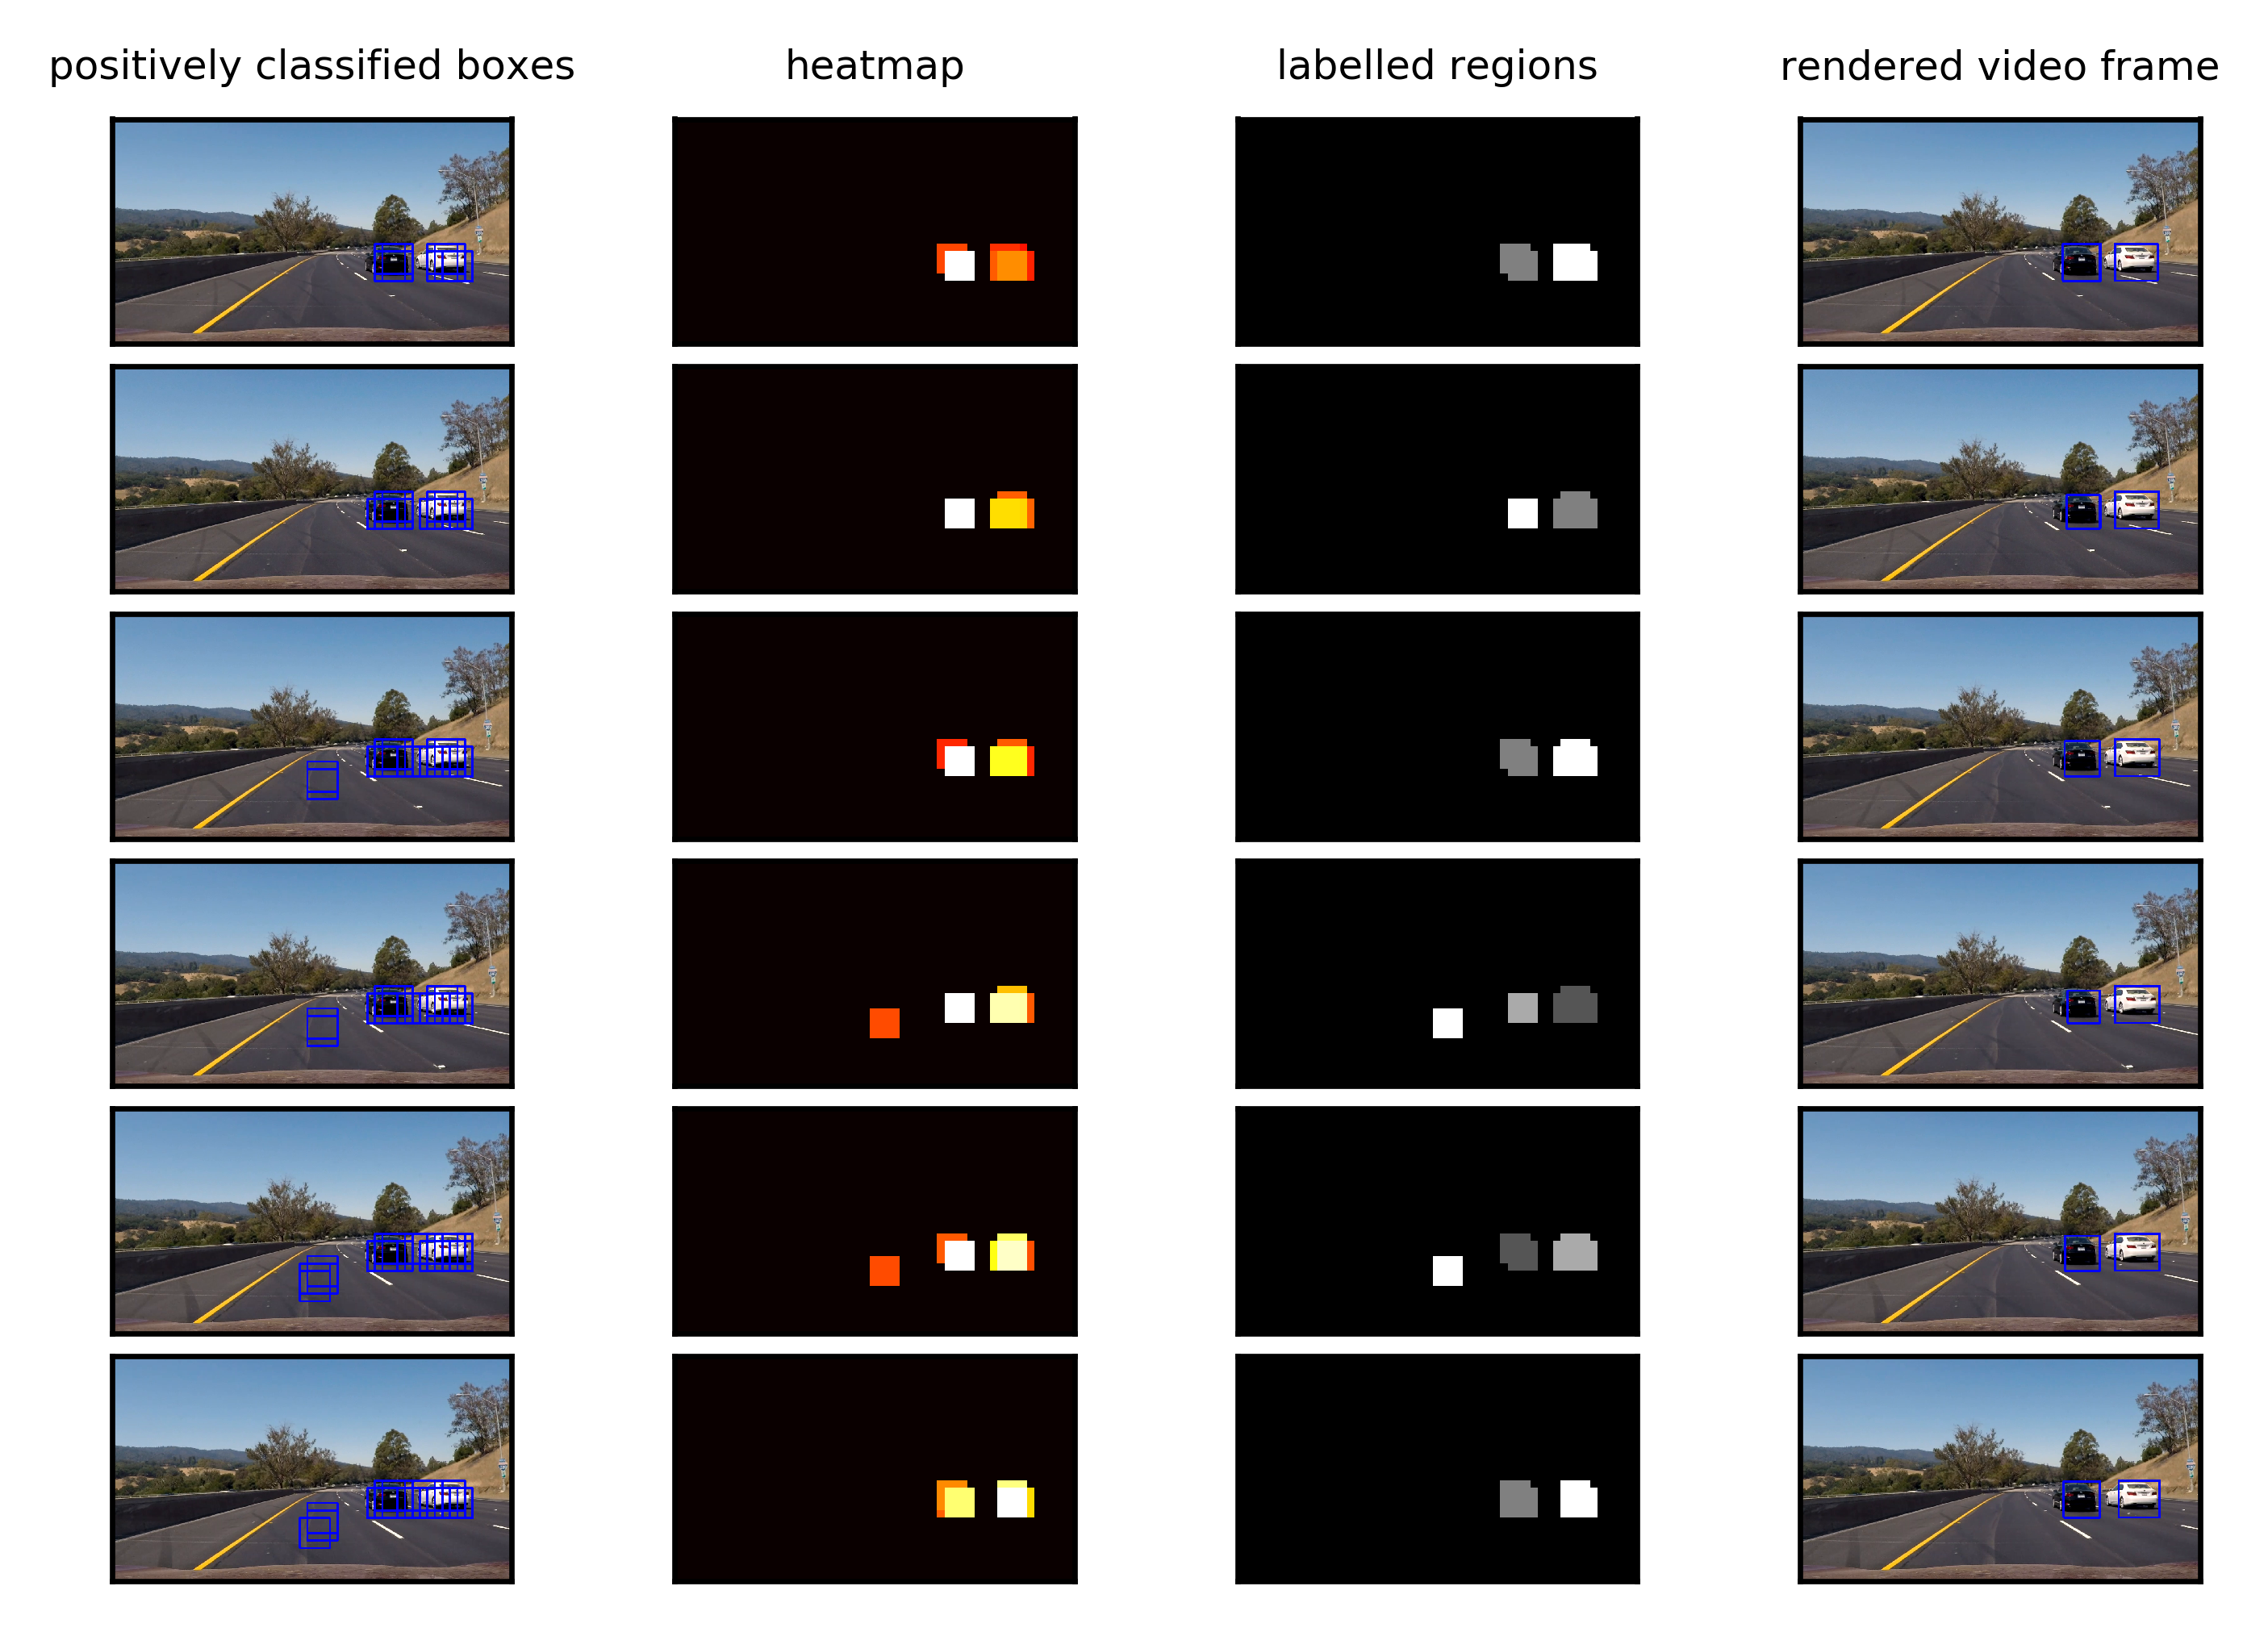

In [37]:
first_frame = 930
last_frame = 936

fig = plt.figure(figsize=(6, 4), dpi=600)
plt.subplots_adjust(wspace=0, hspace=0.1)
for i in range(first_frame, last_frame):
    box_image = mpimg.imread('output_images/boxes'+str(i)+'.png')
    heatmap_image = mpimg.imread('output_images/heatmap'+str(i)+'.png')
    labels_image = mpimg.imread('output_images/labels'+str(i)+'.png')
    final_image = mpimg.imread('output_images/video'+str(i)+'.png')
            
    plt.subplot(6,4,1+(i-first_frame)*4)
    fig = plt.imshow(box_image)
    if i == first_frame:
        fig.axes.set_title('positively classified boxes',fontsize=6) 
    remove_axes(fig)
    
    plt.subplot(6,4,2+(i-first_frame)*4)
    fig = plt.imshow(heatmap_image)
    if i == first_frame:
        fig.axes.set_title('heatmap',fontsize=6) 
    remove_axes(fig)
    
    plt.subplot(6,4,3+(i-first_frame)*4)
    fig = plt.imshow(labels_image)
    if i == first_frame:
        fig.axes.set_title('labelled regions',fontsize=6) 
    remove_axes(fig)
    
    plt.subplot(6,4,4+(i-first_frame)*4)
    fig = plt.imshow(final_image)
    if i == first_frame:
        fig.axes.set_title('rendered video frame',fontsize=6) 
    remove_axes(fig)
    
plt.savefig('.\\examples\\bboxes_heat_labels.png',dpi='figure',bbox_inches='tight', pad_inches=0)